In [2]:
pip install jiwer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 18.6 MB/s eta 0:00:0000:010:01
  Attempting uninstall: levenshtein
    Found existing installation: Levenshtein 0.20.9
    Uninstalling Levenshtein-0.20.9:
      Successfully uninstalled Levenshtein-0.20.9
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
python-levenshtein 0.20.9 requires Levenshtein==0.20.9, but you have levenshtein 0.20.2 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import librosa
import tensorflow as tf
from tensorflow import keras
import tensorflow_io as tfio
from tensorflow.python.keras.activations import relu
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Input, Reshape, BatchNormalization, Conv2D, Bidirectional, SimpleRNN, Dense, TimeDistributed
import matplotlib.pyplot as plt
from IPython import display
from jiwer import wer

In [4]:
DATASET_PATH = '../input/audio-dataset/audio_dataset/'
METADATA_PATH = f'{DATASET_PATH}/df.csv'

FRAME_LENGTH = 256
FRAME_STEP = 160
FFT_LENGTH = 384

AUGMENT = True
NOISE_PROB = 0.25
TIME_SHIFT_PROB = 0.2
PITCH_SHIFT_PROB = 0.25
TIME_STRETCH_PROB = 0.3
SPEC_AUGMENT_PROB = 0.3

BATCH_SIZE = 32
RNN_LAYERS = 7
RNN_UNITS = 1280
EPOCHS = 1
MOMENTUM = 0.99
MIN_LEARNING_RATE = 1e-4
MAX_LEARNING_RATE = 6e-4

In [5]:
metadata_dataframe = pd.read_csv(METADATA_PATH)
metadata_dataframe.head()

,text,audio_id,worker_id,status,version,pool_id,task_id,path,duration,frames,rate
0,"По его словам, на вчерашний вечер у Донбанка «...",2e5fc762-6b7c-4168-8dfd-44e90e908de3,bd83ddb2596e455951c3838ed9061b84,APPROVED,1,12233816,0000baac58--5e813e8b44e47001255de14a,audio_files/2e5fc762-6b7c-4168-8dfd-44e90e908d...,13.02,208320.0,16000.0
1,"Этот процесс так захватывает человека, что он ...",93b47a6a-504c-41e8-b420-1ed5b8360d0d,bd83ddb2596e455951c3838ed9061b84,APPROVED,1,12233816,0000baac58--5e813e8b44e47001255de14a,audio_files/93b47a6a-504c-41e8-b420-1ed5b8360d...,15.02,240320.0,16000.0
2,Это крупнейшее левое движение Западного полуша...,19588ca3-9249-43cd-bc55-374432dffdbd,bd83ddb2596e455951c3838ed9061b84,APPROVED,1,12233816,0000baac58--5e813e8b44e47001255de14a,audio_files/19588ca3-9249-43cd-bc55-374432dffd...,15.48,247680.0,16000.0
3,А результаты проекта будут представлены на еже...,b8155462-6b72-46b6-a28c-71b0ee8fcd84,bd83ddb2596e455951c3838ed9061b84,APPROVED,1,12233816,0000baac58--5e813e8b44e47001255de14a,audio_files/b8155462-6b72-46b6-a28c-71b0ee8fcd...,14.32,229120.0,16000.0
4,За последний месяц лидеры двух стран встречают...,82b5db50-ec4c-493e-b071-e15ab179edda,bd83ddb2596e455951c3838ed9061b84,APPROVED,1,12233816,0000baac58--5e813e8b44e47001255de14a,audio_files/82b5db50-ec4c-493e-b071-e15ab179ed...,11.80,188800.0,16000.0


In [25]:
metadata_dataframe = metadata_dataframe[['text', 'path']].sample(frac=1).reset_index(drop=True)
metadata_dataframe['text'] = metadata_dataframe['text'].str.lower()
metadata_dataframe.head(3)

,text,path
0,"bédérama: лучшая и, возможно, на самом деле ед...",audio_files/1fb8b0e5-67c5-48de-bb22-ad5eea9d6a...
1,"последние переговоры с белорусскими коллегами,...",audio_files/9442f730-c6c7-4cba-901a-51b9bbde65...
2,ему инкриминировали необоснованную невыплату з...,audio_files/27ddceba-fa80-40b1-8204-ce465144f3...


In [ ]:
split = int(len(metadata_dataframe) * 0.90)
df_train = metadata_dataframe[:split]
df_val = metadata_dataframe[split:]

print(f"Size of the training set: {len(df_train)}")
print(f"Size of the training set: {len(df_val)}")

In [7]:
characters = [*"абвгдеёжзийклмнопрстуфхцчшщъыьэюя "]
char_to_num = keras.layers.StringLookup(vocabulary=characters, oov_token="")
num_to_char = keras.layers.StringLookup(vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'а', 'б', 'в', 'г', 'д', 'е', 'ё', 'ж', 'з', 'и', 'й', 'к', 'л', 'м', 'н', 'о', 'п', 'р', 'с', 'т', 'у', 'ф', 'х', 'ц', 'ч', 'ш', 'щ', 'ъ', 'ы', 'ь', 'э', 'ю', 'я', ' '] (size =35)


In [8]:
def add_noise(data, min_amplitude=0.0001, max_amplitude=0.01):
    amplitude = np.random.uniform(min_amplitude, max_amplitude)
    noise = tf.random.normal(tf.shape(data))
    augmented_data = data + amplitude * noise
    return augmented_data.numpy()

def time_shift(data, sampling_rate, shift_max=0.7):
    shift_rate = tf.cast(sampling_rate, tf.float32) * shift_max
    shift = tf.cast(tf.random.uniform(shape=(), minval=1, maxval=shift_rate), tf.int32) 
    direction = np.random.randint(0, 2)
    if direction == 1: augmented_data = tf.concat((tf.zeros(shift), data[:-shift]), axis=0)
    else: augmented_data = tf.concat((data[shift:], tf.zeros(shift)), axis=0)
    return augmented_data.numpy()

def pitch_shift(data, sampling_rate, max_pitch_factor=5):
    pitch_factor = np.random.uniform(-max_pitch_factor, max_pitch_factor)
    return librosa.effects.pitch_shift(data, sr=sampling_rate.numpy(), n_steps=pitch_factor)

def time_stretch(data, min_speed_factor=0.75, max_speed_factor=1.25):
    speed_factor = np.random.uniform(min_speed_factor, max_speed_factor)
    return librosa.effects.time_stretch(data, rate=speed_factor)

def spec_masking(data, max_freq=15, max_time=15, max_freq_n=4, max_time_n=4):
    modifications = [
        [tfio.audio.freq_mask, max_freq, max_freq_n],
        [tfio.audio.time_mask, max_time, max_time_n]
    ]
    for fn, max_val, max_n in modifications:
        n = np.random.uniform(0, max_n + 1)
        for _ in range(int(n)):
            val = int(np.random.uniform(low=1, high=max_val + 1))
            data = fn(data, val).numpy()
    return data

In [9]:
def apply_audio_augmentations(audio, rate):
    augmentations = [
        [add_noise, NOISE_PROB, False],
        [time_shift, TIME_SHIFT_PROB, True],
        [pitch_shift, PITCH_SHIFT_PROB, True],
        [time_stretch, TIME_STRETCH_PROB, False]
    ]
    for fn, probability, rate_needed in augmentations:
        if np.random.uniform() < probability:
            args = [audio]
            if rate_needed: args.append(rate)
            audio = fn(*args)
    return audio

In [10]:
def wav_to_spectrogram(wav_path, augment):
    file = tf.io.read_file(wav_path)
    audio, rate = tf.audio.decode_wav(file, desired_channels=1)
    audio = tf.squeeze(audio, axis=-1)
    audio = audio.numpy()
    if augment:
        audio = apply_audio_augmentations(audio, rate)
    spectrogram = tf.signal.stft(audio, frame_length=FRAME_LENGTH, frame_step=FRAME_STEP, fft_length=FFT_LENGTH)
    magnitude = tf.math.pow(tf.abs(spectrogram), 0.5)
    # normalization
    means = tf.math.reduce_mean(magnitude, 1, keepdims=True)
    stddevs = tf.math.reduce_std(magnitude, 1, keepdims=True)
    normalized = (magnitude - means) / (stddevs + 1e-10)
    if augment and np.random.uniform() < SPEC_AUGMENT_PROB:
        normalized = spec_masking(normalized)
    return normalized

def encode_single_sample(wav_file, label, augment):
    spectrogram = wav_to_spectrogram(DATASET_PATH + wav_file.decode('utf-8'), augment=AUGMENT)
    label_mapped = char_to_num(list(label.decode('utf-8')))
    return spectrogram, label_mapped

In [11]:
def create_dataset(data, augment=False):
    dataset = tf.data.Dataset.from_tensor_slices((data['path'], data['text']))
    return dataset.map(
            lambda file, label: tf.numpy_function(encode_single_sample, (file, label, augment), (tf.float32, tf.int64))
        ) \
        .padded_batch(BATCH_SIZE, padded_shapes=((None, None), (None,))) \
        .prefetch(buffer_size=tf.data.AUTOTUNE)
             
train_dataset = create_dataset(df_train, AUGMENT)
validation_dataset = create_dataset(df_val)

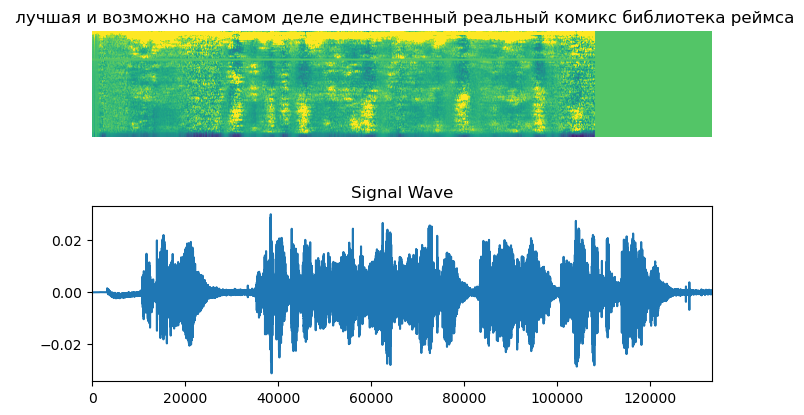

In [58]:
fig = plt.figure(figsize=(8, 5))
for batch in train_dataset.take(1):
    spectrogram = np.transpose(batch[0][0])
    label = batch[1][0]
    label = tf.strings.reduce_join(num_to_char(label)).numpy().decode('utf-8')
    ax = plt.subplot(2, 1, 1)
    ax.imshow(spectrogram, vmax=1)
    ax.set_title(label)
    ax.axis('off')
    file = tf.io.read_file(DATASET_PATH + df_train['path'][0])
    audio, rate = tf.audio.decode_wav(file)
    audio = audio.numpy()
    ax = plt.subplot(2, 1, 2)
    plt.plot(audio)
    ax.set_title('Signal Wave')
    ax.set_xlim(0, len(audio))
    display.display(display.Audio(np.transpose(audio), rate=rate.numpy()))
plt.show()

In [12]:
def ctc_loss(y_true, y_pred):
    batch_len = tf.shape(y_true)[0]
    get_length = lambda x: tf.shape(x)[1] * tf.ones(shape=(batch_len, 1), dtype=tf.int32)
    input_len, label_len = [get_length(x) for x in [y_pred, y_true]]
    return keras.backend.ctc_batch_cost(y_true, y_pred, input_len, label_len)

In [13]:
def build_model(input_dim, output_dim):
    conv_architecture = [
        {'filters': 32, 'kernel': [11, 41], 'strides': [2, 2], 'padding': 'same'},
        {'filters': 32, 'kernel': [11, 21], 'strides': [1, 2], 'padding': 'same'},
        {'filters': 96, 'kernel': [11, 21], 'strides': [1, 2], 'padding': 'same'}
    ]
    clipped_relu = lambda x: relu(x, max_value=20)
    conv_layer = lambda x: Conv2D(
        filters=x['filters'], kernel_size=x['kernel'], strides=x['strides'], activation=clipped_relu, padding=x['padding']
    )
    rnn_layer = lambda: Bidirectional(SimpleRNN(RNN_UNITS, return_sequences=True), merge_mode='sum')
    
    model = Sequential([
        Input((None, input_dim)),
        Reshape((-1, input_dim, 1)),
        BatchNormalization(),
        *[conv_layer(x) for x in conv_architecture],
        Reshape((-1, 2400)),
        BatchNormalization(),
        *[rnn_layer() for _ in range(RNN_LAYERS)],
        BatchNormalization(),
        Dense(1024, activation=clipped_relu),
        Dense(output_dim + 1, activation='softmax')
    ])
    opt = keras.optimizers.Adam(learning_rate=MAX_LEARNING_RATE, beta_1=MOMENTUM)
    model.compile(optimizer=opt, loss=ctc_loss)
    return model

In [14]:
model = build_model(input_dim=FFT_LENGTH // 2 + 1, output_dim=char_to_num.vocabulary_size())
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, None, 193, 1)      0         
                                                                 
 batch_normalization (BatchN  (None, None, 193, 1)     4         
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, None, 97, 32)      14464     
                                                                 
 conv2d_1 (Conv2D)           (None, None, 49, 32)      236576    
                                                                 
 conv2d_2 (Conv2D)           (None, None, 25, 96)      709728    
                                                                 
 reshape_1 (Reshape)         (None, None, 2400)        0         
                                                        

In [374]:
decode_str = lambda chars: tf.strings.reduce_join(num_to_char(chars)).numpy().decode('utf-8')

def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0]
    return [decode_str(result) for result in results]

class CallbackEval(keras.callbacks.Callback):
    def __init__(self, dataset):
        super().__init__()
        self.dataset = dataset

    def on_epoch_end(self, epoch: int, logs=None):
        predictions = list()
        targets = list()
        for batch in self.dataset:
            tracks, labels = batch
            results_encoded = model.predict(tracks, verbose=0)
            batch_predictions = decode_batch_predictions(results_encoded)
            predictions.extend(batch_predictions)
            targets.extend([decode_str(label) for label in labels])
        wer_score = wer(targets, predictions)
        delimiter = lambda: print('-' * 100)
        
        delimiter()
        print(f'Word Error Rate: {wer_score:.4f}')
        delimiter()
        for i in np.random.randint(0, len(predictions), 2):
            print(f'Target: {targets[i]}')
            print(f'Prediction: {predictions[i]}')
            delimiter()

In [375]:
validation_callback = CallbackEval(validation_dataset)
plateau_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.83, patience=2, min_lr=MIN_LEARNING_RATE)

history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=EPOCHS,
    callbacks=[validation_callback, plateau_lr],
)

500/500 [==============================] - ETA: 0s - loss: 380.3784 ----------------------------------------------------------------------------------------------------
Word Error Rate: 1.0000
----------------------------------------------------------------------------------------------------
Target: многие фиксированные точки для разработки новых реакторов
Prediction: 
----------------------------------------------------------------------------------------------------
Target:  если мы выпивку достали вас угостить забрать никак не можем выпьете сами
Prediction: 
----------------------------------------------------------------------------------------------------
500/500 [==============================] - 6400s 13s/step - loss: 380.3784 - val_loss: 279.2018 - lr: 6.0000e-04
